In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [4]:
trans_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [ ]:
trans_data

In [5]:
identity_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [7]:
trans_data.sort_values(by='TransactionDT',inplace=True)

In [6]:
merged_df = pd.merge(trans_data,identity_data,on='TransactionID',how='left')

In [ ]:
merged_df

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
trans_data.shape

In [8]:
Y = merged_df[['isFraud']].copy()
x_cols = [c for c in merged_df.columns if c != 'isFraud']
x_data = merged_df[x_cols].copy()
x_train, T_x, y_train, T_y = train_test_split(x_data, Y,test_size = 0.2, random_state=42) 
x_val, x_test, y_val, y_test = train_test_split(T_x, T_y,test_size = 0.5, random_state=42)

In [ ]:
print(x_train.shape,x_val.shape,x_test.shape)

In [ ]:
x_train.dtypes

Cleaning

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyImputer(BaseEstimator,TransformerMixin):
    def __init__(self,strategy:str = 'most_frequent'):
        self.imputer = None
        self.strategy = strategy

    def fit(self, x, y=None):
        x_copy = x.copy()
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(x_copy)
        return self

    def transform(self, x):
        x_transformed = x.copy()
        ret_val = pd.DataFrame(self.imputer.transform(x),columns=x_transformed.columns)

        return ret_val.astype(x_transformed.dtypes)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class CatToNum(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.woe_mappings = {}
        self.woe_columns = []
        self.woe_columns_fill_na = {}

    def fit(self, X, y=None):
        # Generate Fill Na Values Just in Case
        woe_columns = [c for c in X.columns if X[c].dtype == 'object']
        print()
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X[woe_columns].copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            
            woe_mappings[col] = woe_dict

        self.woe_mappings = woe_mappings
        self.woe_columns = woe_columns

        return self

    def transform(self, x):
        x_transformed = x.copy()
        for col in self.woe_columns:
            x_transformed[f'{col}_woe'] = x_transformed[col].map(self.woe_mappings[col])
            x_transformed.drop(columns=[col], inplace=True)

            x_transformed[f'{col}_woe'] = x_transformed[f'{col}_woe'].fillna(
                self.woe_mappings[col][self.woe_columns_fill_na[col]]
            )

        # print(x_transformed[self.woe_columns])
        return x_transformed     

Feature Engineering

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.scaler = scaler
        self.num_cols = []

    def fit(self, X:pd.DataFrame, y=None):
        if self.scaler == None:
            return self
        self.num_cols = [c for c in X if X[c].dtype != 'object']
        df_copy = X[self.num_cols].copy()
        
        self.scaler.fit(X[self.num_cols].copy())
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.scaler == None:
            return X_copy
        X_copy[self.num_cols] = pd.DataFrame(self.scaler.transform(X_copy[self.num_cols]),columns=self.num_cols)
        return X_copy

In [ ]:
imputed = MyImputer().fit_transform(x_train,y_train)
imputed = CatToNum().fit_transform(imputed,y_train);

In [ ]:
imputed

In [ ]:
num_cols = [c for c in x_train.columns if x_train[c].dtype != 'object']
Scaler().fit(imputed,y_train).transform(imputed)

feature selection

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class NaHeavy(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.drop_cols = []

    def fit(self, x, y=None):
        self.drop_cols = [c for c in x.columns if x[c].isna().sum() > x.shape[0]*self.threshold]
        print(f'Na dropped {len(self.drop_cols)} features')
        return self

    def transform(self, x):
        return x.drop(columns = self.drop_cols)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.features_to_drop = []

    def fit(self, X:pd.DataFrame, y):
        num_cols = [c for c in X.columns if X[c].dtype != 'object']
        X_copy = X[num_cols].copy()
        X_copy['target'] = y
        corr_matrix = X_copy.corr().abs()

        target_cor = corr_matrix.pop('target')
        corr_matrix.drop(labels='target', axis=0,inplace=True)
        
        high_corr_pairs = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


        features_to_drop = set()
        for feat1, feat2, _ in high_corr_pairs:
            if target_cor[feat1] < target_cor[feat2]:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)
        self.features_to_drop = list(features_to_drop)
        print('Dropped Features',len(self.features_to_drop))
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        return X_copy.drop(columns=self.features_to_drop)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class VarianceFilter(BaseEstimator,TransformerMixin):
    def __init__(self, left_freshold:float = 0.003, right_threshold:float=50.00):
        self.left_threshold = left_freshold
        self.right_threshold = right_threshold
        self.drop_features = []

    def fit(self, X:pd.DataFrame, y):
        num_values = [c for c in X.columns if X[c].dtype != 'object']
        l = []

        for c in num_values:
            counts = X[c].value_counts()
            all_c = X.shape[0]-X[c].isna().sum()
            if ((float(max(counts))/float(all_c)*100.00) > self.right_threshold or 
                (float(max(counts))/float(all_c)*100.00) < self.left_threshold):
                l.append(c)
        

        print('var dropped : ',len(l))
        self.drop_features = l
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        return X_copy.drop(columns=self.drop_features)

In [1]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 73.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [28]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [32]:
num_cols = x_train[[c for c in x_train.columns if x_train[c].dtype != 'object']]

In [17]:
pipline = Pipeline(steps=[
        ('naheavy', NaHeavy(0.9)),
        ('var_filter', VarianceFilter(left_freshold =  0.002,right_threshold = 100.00)),
        ('imputer', MyImputer()),
        ('corr',CorrelationFilter(0.98)),
        ('cat2num', CatToNum()),
        ('scaler', Scaler()),
        ('model', LogisticRegression(max_iter=1000))
    ])

In [18]:
imb_pipeline = ImbPipeline(steps=[
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.10)),  # Undersampling step
    ('oversampler', RandomOverSampler(random_state=42, sampling_strategy=0.30)),
    ('classifier', pipline)  # Your classifier
])


In [ ]:
y_train.groupby('isFraud').value_counts()

In [ ]:
x,y = s.fit_resample(x_train, y_train)


In [ ]:
y_val.groupby('isFraud').value_counts()

In [ ]:
from sklearn.metrics import roc_curve, auc

na_threshold = [80.00,85.00,90.00,95.00,100.0]
for th in na_threshold:
    pipline = Pipeline(steps=[
        ('vat_filter', VarianceFilter(right_threshold=th)),
        ('naheavy', NaHeavy(0.9)),
        ('imputer', MyImputer()),
        ('corr',CorrelationFilter(1.0)),
        ('cat2num', CatToNum()),
        ('scaler', Scaler()),
        ('model', LogisticRegression(max_iter = 1000))
    ])

    imb_pipeline = ImbPipeline(steps=[
        ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.1)),  # Undersampling step
        ('classifier', pipline)  # Your classifier
    ])
    # x,y  = RandomUnderSampler(random_state=42, sampling_strategy=0.1).fit_resample(x_train, y_train)
    
    model = pipline.fit(x_train,y_train);
    
    val_proba = model.predict_proba(x_val)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
    val_roc_auc = auc(val_fpr, val_tpr)
    print("roc validation : ",th, val_roc_auc)

    train_proba = model.predict_proba(x_train)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
    val_roc_auc = auc(train_fpr, train_tpr)
    print("roc train : ",th, train_roc_auc)

    val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
    val_auc_pr = auc(val_recall, val_precision)
    print("roc_pr validation : ",th, val_auc_pr)

    train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
    train_auc_pr = auc(train_recall, train_precision)
    print("roc_pr train : ",th, train_auc_pr)    


In [ ]:
y_train.groupby('isFraud').value_counts()

In [ ]:
y_train

In [19]:
model = imb_pipeline.fit(x_train,y_train)

Na dropped 11 features
var dropped :  0
Dropped Features 49

Processing ProductCD...
Processing card4...
Processing card6...
Processing P_emaildomain...
Processing R_emaildomain...
Processing M1...
Processing M2...
Processing M3...
Processing M4...
Processing M5...
Processing M6...
Processing M7...
Processing M8...
Processing M9...
Processing id_12...
Processing id_15...
Processing id_16...
Processing id_28...
Processing id_29...
Processing id_30...
Processing id_31...
Processing id_33...
Processing id_34...
Processing id_35...
Processing id_36...
Processing id_37...
Processing id_38...
Processing DeviceType...
Processing DeviceInfo...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
train_proba = model.predict_proba(x_train)

In [ ]:
data = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [ ]:
model.predict_proba(data)

In [21]:
val_proba = model.predict_proba(x_val)

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_curve,roc_curve, auc

In [ ]:
train_pred

In [23]:
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
val_roc_auc = auc(val_fpr, val_tpr)
val_roc_auc

0.8669838267229063

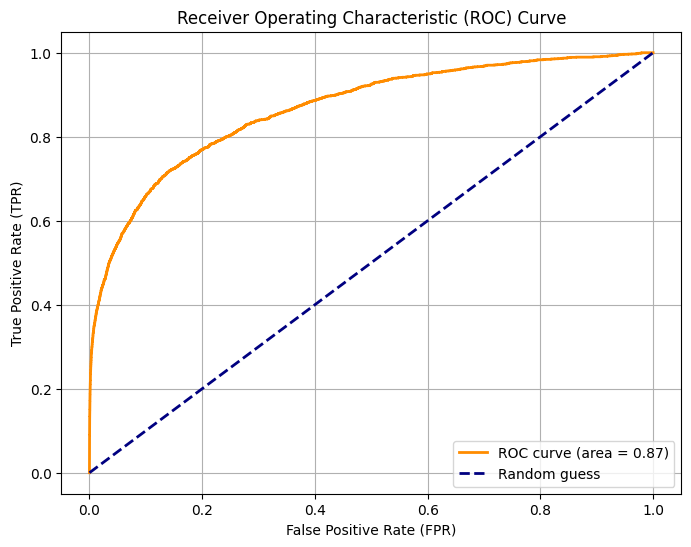

AUC: 0.87


In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {val_roc_auc:.2f}")

In [25]:
val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
val_auc_pr = auc(val_recall, val_precision)
val_auc_pr

0.44234136383621203

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(val_recall,val_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {val_auc_pr:.2f}")

In [26]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
train_roc_auc = auc(train_fpr, train_tpr)
train_roc_auc

0.869490190021641

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {train_roc_auc:.2f}")

In [27]:
train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
train_auc_pr = auc(train_recall, train_precision)
train_auc_pr

0.4561252602081557

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_recall,train_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {train_auc_pr:.2f}")

In [ ]:
!pip install -q dagshub mlflow

In [ ]:
import dagshub
dagshub.init(repo_owner='azhgh22', repo_name='ML2_fraud_detection', mlflow=True)

In [ ]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
mlflow.set_experiment("Logistic_Regression")
with mlflow.start_run(run_name="LogReg:run5"):
    mlflow.log_params({
        'used_tables' : ['transaction.csv','identity.csv'],
        'join method' : {
              'on' : 'TransactionID',
              'how' : 'right'
        },
        'cross_val_split': {
            'train' : 0.8,
            'validation' : 0.1,
            'test' : 0.1,
            'random_state' : 42
        },
        'variation_filter' : {
            'left_threshold' : 0.002,
            'right_threshold' : 85.00
        },
        'drop_na_heavy_columns_threshold' : 0.9,
        'na imputer' : 'SimpleImputer(strategy=\'most_drequent\')',
        'categorical columns' : 'woe encoding',
        'correlation filter threshold' : 0.98,
        'scaler' : 'StandardScaler',
        'undersampling' : {
            'class' : 'RandomUnderSampler',
            'random_state' : 42,
            'sampling_strategy' : 0.1
        },
        'oversampling' : {
            'class' : 'RandomOverSampler',
            'random_state' : 42,
            'sampling_strategy' : 0.1
        }
    })
    mlflow.log_metrics({
        'train_roc_auc': train_roc_auc,
        'test__roc_auc' : val_roc_auc, 
        'train_pr_auc' : train_auc_pr,
        'val_pr_auc' : val_auc_pr
    })

    plt.figure(figsize=(8, 6))
    plt.plot(val_recall,val_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("val_roc_pr.png")
    plt.show()
    mlflow.log_artifact("val_roc_pr.png")
    print(f"AUC-PR: {val_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(train_recall,train_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("train_roc_pr.png")
    plt.show()
    mlflow.log_artifact("train_roc_pr.png")
    print(f"AUC-PR: {train_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("validation_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("validation_roc.png")

    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("train_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("train_roc.png")
    
    mlflow.sklearn.log_model(model,'LogisticRegression')
    
    
    mlflow.end_run()

In [ ]:
cat_values = [c for c in x_train.columns if x_train[c].dtype == 'object']
num_values = [c for c in x_train.columns if x_train[c].dtype != 'object']
print(len(cat_values))
print(len(num_values))

In [ ]:
vs = pd.DataFrame()
vs.index = num_values
vs['std'] = x_train[num_values].std()

In [ ]:
vs['std'].describe(x/100 for x in range(2, 101, 2))

In [ ]:
# value_counts = x_train[num_values].value_counts()

In [ ]:
value_counts = x_train['TransactionAmt'].value_counts()
    

In [ ]:
value_counts.head(1).iloc[0]

In [ ]:
max(value_counts)

In [ ]:
sum(value_counts)

In [ ]:
l = [c for c in num_values if (float(max(x_train[c].value_counts()))/float(x_train.shape[0])*100.00) > 50.00 or (float(max(x_train[c].value_counts()))/float(x_train.shape[0])*100.00)<0.002]

In [ ]:
len(l)

In [ ]:
s = RandomUnderSampler(random_state=42, sampling_strategy=0.1)

In [ ]:
x,y = s.fit_resample(x_train, y_train)

In [ ]:
import matplotlib.pyplot as plt
num_values = [c for c in x.columns if x[c].dtype != 'object']
for c in num_values:
    plt.hist(x[c], bins=50, edgecolor='black')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title('Histogram of Numerical Feature')
    plt.show()
    # print(vs['std'][c])
    # print(x_train[c].value_counts())
    value_counts = x[c].value_counts()
    print('max count:', max(value_counts))
    print('all rows : ',x.shape[0] - x[c].isna().sum())
    print('% :  ',(float(max(value_counts))/float(x.shape[0] - x[c].isna().sum())*100.00))
    print(x[c].nunique())

In [ ]:
import matplotlib.pyplot as plt
for c in num_values:
    plt.hist(x_train[c], bins=50, edgecolor='black')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title('Histogram of Numerical Feature')
    plt.show()
    print(vs['std'][c])
    # print(x_train[c].value_counts())
    value_counts = x_train[c].value_counts()
    print('max count:', max(value_counts))
    print('all rows : ',x_train.shape[0])
    print('% :  ',(float(max(value_counts))/float(x_train.shape[0])*100.00))
    print(x_train[c].nunique())